### Build the model - flow vs binary extreme snowmelt

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import make_scorer, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


In [2]:
# setup for search grid
from scipy.stats import loguniform


class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)


In [3]:
# build scorer function
def auc_pr_score(y_true, y_pred):
	precision, recall, _ = precision_recall_curve(y_true, y_pred)
	return auc(recall, precision)


auc_pr = make_scorer(auc_pr_score, greater_is_better=True)


In [4]:
all_data_clean = pd.read_csv('../all_data_clean.csv')

all_data_clean.head()


,Unnamed: 0,date,snow_depth,depth_diff,binary,flow_site_id,snow_site_id,distance,flow,year,month,flow_prev_month,flow_prev_month_max,site_id
0,0,1945-05-23,0.0,0.0,0,51.0,157010.0,35296.19718,182.0,1945,5,413.3518,1746.0,51.0 157010.0
1,1,1945-05-24,0.0,0.0,0,51.0,157010.0,35296.19718,176.0,1945,5,413.3518,1746.0,51.0 157010.0
2,2,1945-05-25,0.0,0.0,0,51.0,157010.0,35296.19718,164.0,1945,5,413.3518,1746.0,51.0 157010.0
3,3,1945-05-26,0.0,0.0,0,51.0,157010.0,35296.19718,152.0,1945,5,413.3518,1746.0,51.0 157010.0
4,4,1945-05-27,0.0,0.0,0,51.0,157010.0,35296.19718,143.0,1945,5,413.3518,1746.0,51.0 157010.0


In [8]:
# split training, test, validation data
scores = {}
n_splits = 5

all_data_clean = all_data_clean.sort_values(by=['date'], ascending=True).reset_index(drop=True)
enc = OneHotEncoder(handle_unknown='ignore')
months_df = pd.DataFrame(enc.fit_transform(
    all_data_clean[['month']]).toarray())
#X = all_data_clean[['flow']].join(months_df)
X = all_data_clean[['flow', 'month', 'year']]
y = all_data_clean['binary']
tscv = TimeSeriesSplit(n_splits=n_splits)


In [9]:
# baseline model: naive predictor (always zero)
y_pred = np.zeros(y.shape)
auc_score = auc_pr_score(y, y_pred)
scores['baseline'] = auc_score


In [10]:
# a test with logistic regression

tmp_scores = []
for train_index, test_index in tscv.split(X):

    data_train = X.loc[X.index.intersection(train_index), :]
    target_train = y.loc[y.index.intersection(train_index)]

    data_test = X.loc[X.index.intersection(test_index), :]
    target_test = y.loc[y.index.intersection(test_index)]

    clf = LogisticRegression(class_weight={0: 1, 1: 10})
    clf.fit(data_train, target_train)

    preds = clf.predict(data_test)
    y_pred = pd.Series(
        np.round(preds), index=data_test.index, name='predicted')
    gridsearchpreds = pd.concat([target_test, y_pred], axis=1)
    print(gridsearchpreds.value_counts())

    auc_score = auc_pr_score(target_test, preds)
    print(auc_score)

    tmp_scores.append(auc_score)

# this is the average accuracy over all folds
average_score = np.mean(tmp_scores)
scores['logistic regression'] = average_score


binary  predicted
0       0            228513
1       0             21066
0       1              1376
1       1                87
dtype: int64
0.07374699307700014
binary  predicted
0       0            201825
        1             34617
1       0             12469
        1              2131
dtype: int64
0.12680871712697767
binary  predicted
0       0            198617
        1             35486
1       0             14220
        1              2719
dtype: int64
0.14416487658016947
binary  predicted
0       0            208398
        1             32104
1       0              8805
        1              1735
dtype: int64
0.12547850937893773
binary  predicted
0       0            217463
        1             25542
1       0              6653
        1              1384
dtype: int64
0.12505261690811537


In [11]:
# LightGBM-like ensemble model - parameters tuned for this dataset

index_output = tscv.split(X)

clf = HistGradientBoostingClassifier(
    loss='binary_crossentropy', random_state=42, verbose=0).fit(X, y)
param_grid = {
    'learning_rate': (0.1, 1, 5, 7, 10, 20, 50, 100),
   	#'max_iter': (100, 200, 300, 500, 1000),
    'max_leaf_nodes': (1, 2, 3, 5, 10, 30)}

# consider using RandomizedSearchCV instead of GridSearchCV
# gs = GridSearchCV(clf, param_grid=param_grid, cv=index_output, scoring=auc_pr, n_jobs=-1, verbose=1)
# gs.fit(X, y)
# gs.best_params_

param_distributions = {
    'l2_regularization': loguniform(1e-6, 1e3),
    'learning_rate': loguniform(0.001, 10),
    'max_leaf_nodes': loguniform_int(2, 256),
    'min_samples_leaf': loguniform_int(1, 100),
    'max_bins': loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X, y)
l2_regularization = model_random_search.best_params_['l2_regularization']
learning_rate = model_random_search.best_params_['learning_rate']
max_leaf_nodes = model_random_search.best_params_['max_leaf_nodes']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
max_bins = model_random_search.best_params_['max_bins']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'l2_regularization': 0.04370362167050531,
 'learning_rate': 0.03132616481962874,
 'max_bins': 7,
 'max_leaf_nodes': 54,
 'min_samples_leaf': 16}

In [12]:
# LightGBM-like ensemble model - cross validation with new parameters

new_regressor = HistGradientBoostingClassifier(
    loss='binary_crossentropy', random_state=42, l2_regularization=131.12520655871074,
    learning_rate=learning_rate,
    max_bins=max_bins,
    max_leaf_nodes=max_leaf_nodes,
    min_samples_leaf=min_samples_leaf,
   	verbose=0)
index_output = tscv.split(X)

cv_results = cross_validate(
    new_regressor,
    X,
    y,
    cv=index_output,
    scoring=auc_pr,
)

mean_score = np.mean(cv_results['test_score'])
scores['histogram gradient boosting'] = mean_score


In [13]:
# check model predictions
y_pred = new_regressor.fit(X, y).predict(X)
y_pred = pd.Series(np.round(y_pred), index=X.index, name='predicted')
np.unique(y_pred)


array([0])

In [14]:
# look at confusion matrix
gridsearchpreds = pd.concat([y, y_pred], axis=1)
gridsearchpreds.value_counts()


binary  predicted
0       0            1420814
1       0              85438
dtype: int64

In [15]:
# Random forest model

index_output = tscv.split(X)

clf = RandomForestClassifier(random_state=42, verbose=0)

param_distributions = {
	'n_estimators': loguniform_int(2, 256),
	'criterion': ['gini', 'entropy'],
	'min_samples_split': loguniform_int(2, 256),
	'min_samples_leaf': loguniform_int(1, 100),
	'class_weight': [{0: 1, 1: 10}, {0: 1, 1: 5}, {0: 1, 1: 2}, {0: 1, 1: 1}],
}

model_random_search = RandomizedSearchCV(
    clf, param_distributions=param_distributions, n_iter=200, n_jobs=-1, scoring=auc_pr,
    cv=index_output, verbose=1,
)
model_random_search.fit(X, y)
n_estimators = model_random_search.best_params_['n_estimators']
criterion = model_random_search.best_params_['criterion']
min_samples_split = model_random_search.best_params_['min_samples_split']
min_samples_leaf = model_random_search.best_params_['min_samples_leaf']
class_weight = model_random_search.best_params_['class_weight']
model_random_search.best_params_


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'min_samples_leaf': 96,
 'min_samples_split': 50,
 'n_estimators': 8}

In [16]:
# random forest - cross validation with new parameters

new_regressor = RandomForestClassifier(
    random_state=42,
   	n_jobs=-1, verbose=0,
   	criterion=criterion,
   	min_samples_leaf=min_samples_leaf,
   	min_samples_split=min_samples_split,
   	n_estimators=n_estimators
)
index_output = tscv.split(X)

cv_results = cross_validate(
    new_regressor,
    X,
    y,
    cv=index_output,
    scoring=auc_pr,
)

mean_score = np.mean(cv_results['test_score'])
scores['random forest'] = mean_score


In [17]:
# check model predictions
y_pred = new_regressor.fit(X, y).predict(X)
y_pred = pd.Series(np.round(y_pred), index=X.index, name='predicted')
np.unique(y_pred)


array([0, 1])

In [18]:
# look at confusion matrix
gridsearchpreds = pd.concat([y, y_pred], axis=1)
gridsearchpreds.value_counts()


binary  predicted
0       0            1420332
1       0              84555
        1                883
0       1                482
dtype: int64

In [19]:
# try with RNN 

values = all_data_clean[['flow', 'flow_prev_month', 'binary']].values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df = pd.DataFrame(scaled, columns=['flow', 'flow_prev_month', 'binary'])
print(df.head())


       flow  flow_prev_month  binary
0  0.027101         0.053196     0.0
1  0.024271         0.053196     0.0
2  0.023956         0.053196     0.0
3  0.023641         0.053196     0.0
4  0.023327         0.038382     0.0


In [20]:
# split into train and test sets
values = df.values
n_train_hours = int(np.round(len(df) * 0.8))
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1205002, 1, 2) (1205002,) (301250, 1, 2) (301250,)


Epoch 1/10
16737/16737 - 50s - loss: 0.9742 - val_loss: 0.4777 - 50s/epoch - 3ms/step
Epoch 2/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step
Epoch 3/10
16737/16737 - 47s - loss: 0.9742 - val_loss: 0.4777 - 47s/epoch - 3ms/step
Epoch 4/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step
Epoch 5/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step
Epoch 6/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step
Epoch 7/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step
Epoch 8/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step
Epoch 9/10
16737/16737 - 47s - loss: 0.9742 - val_loss: 0.4777 - 47s/epoch - 3ms/step
Epoch 10/10
16737/16737 - 48s - loss: 0.9742 - val_loss: 0.4777 - 48s/epoch - 3ms/step


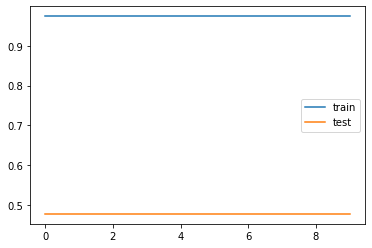

In [21]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='binary_crossentropy',
              optimizer='sgd')  # optimizers: adam, sgd
# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=20)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [22]:
# make a prediction
y_pred = model.predict(test_X).flatten()
y_pred = pd.Series(np.round(y_pred), name='predicted')
np.unique(y_pred)


array([-0.], dtype=float32)

In [25]:
# look at confusion matrix
test_y = pd.Series(test_y, name='actual')
score = auc_pr_score(test_y, y_pred)
scores['RNN'] = score
gridsearchpreds = pd.concat([test_y, y_pred], axis=1)
gridsearchpreds.value_counts()


actual  predicted
0.0     -0.0         291920
1.0     -0.0           9330
dtype: int64

In [26]:
# all AUC-PR
for key, value in scores.items():
	print(key, value)


baseline 0.5283611241678019
logistic regression 0.11905034261424008
histogram gradient boosting 0.5283892735080186
random forest 0.5283892735080186
RNN 0.5154854771784232
